In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.sampling_jax
import seaborn as sns

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.


In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.io import DataFile, data_path
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
SEED = 847
np.random.seed(SEED)
arviz_config()

## Data

In [5]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.query("screen == 'broad'").reset_index(drop=True)

In [6]:
crispr_data_manager = CrisprScreenDataManager(
    DataFile.DEPMAP_CRC_SUBSAMPLE, transformations=[_broad_only]
)
crc_data = crispr_data_manager.data

In [7]:
for col in ["sgrna", "hugo_symbol", "depmap_id"]:
    print(f"'{col}': {crc_data[col].nunique()}")

'sgrna': 162
'hugo_symbol': 103
'depmap_id': 8


## Modeling

In [103]:
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel

In [104]:
crc_model = LineageHierNegBinomModel(lineage="colorectal")

[07/04/22 07:09:29] INFO     Lineage: colorectal               ]8;id=135505;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=817237;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#283\283]8;;\

INFO:speclet:Lineage: colorectal


                    INFO     Number of genes: 103              ]8;id=803351;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=563120;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#284\284]8;;\

INFO:speclet:Number of genes: 103


                    INFO     Number of sgRNA: 162              ]8;id=555010;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=548500;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#285\285]8;;\

INFO:speclet:Number of sgRNA: 162


                    INFO     Number of cell lines: 8           ]8;id=616799;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=87422;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#286\286]8;;\

INFO:speclet:Number of cell lines: 8


                    INFO     Number of cancer genes: 3         ]8;id=989964;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=90678;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#287\287]8;;\

INFO:speclet:Number of cancer genes: 3


                    INFO     Number of screens: 1              ]8;id=468564;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=527737;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#288\288]8;;\

INFO:speclet:Number of screens: 1


                    INFO     Number of data points: 1296       ]8;id=837191;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=179406;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#289\289]8;;\

INFO:speclet:Number of data points: 1296


                    WARNING  Only 1 screen detected - ignoring ]8;id=469196;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=682601;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#449\449]8;;\
                             variable `p`.                                                   

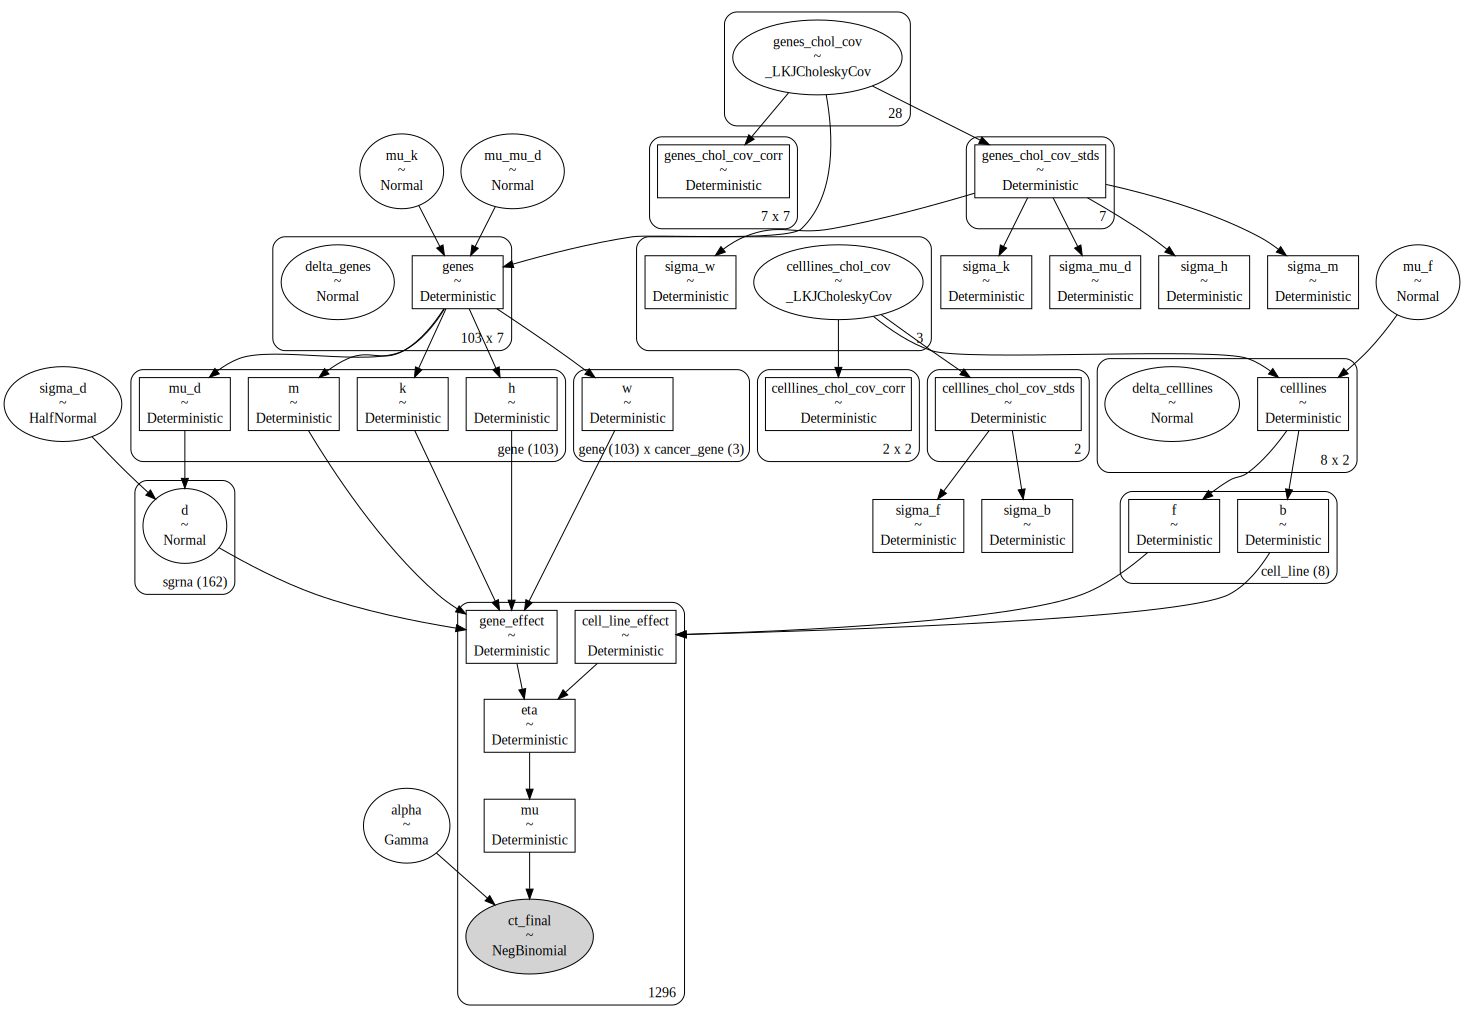

In [105]:
crc_pymc_model = crc_model.pymc_model(crispr_data_manager.data.copy())
pm.model_to_graphviz(crc_pymc_model)

In [106]:
with crc_pymc_model:
    pm_prior_pred = pm.sample_prior_predictive(random_seed=SEED)

In [107]:
pm_pred_draws = pm_prior_pred.prior_predictive["ct_final"].values.squeeze()
print(f"min: {np.min(pm_pred_draws):,d}\nmax: {np.max(pm_pred_draws):,d}")

min: 0
max: 24,833,558


In [108]:
obs = crc_data["counts_final"].astype(int)
print(f"min: {np.min(obs):,d}\nmax: {np.max(obs):,d}")

min: 0
max: 9,819


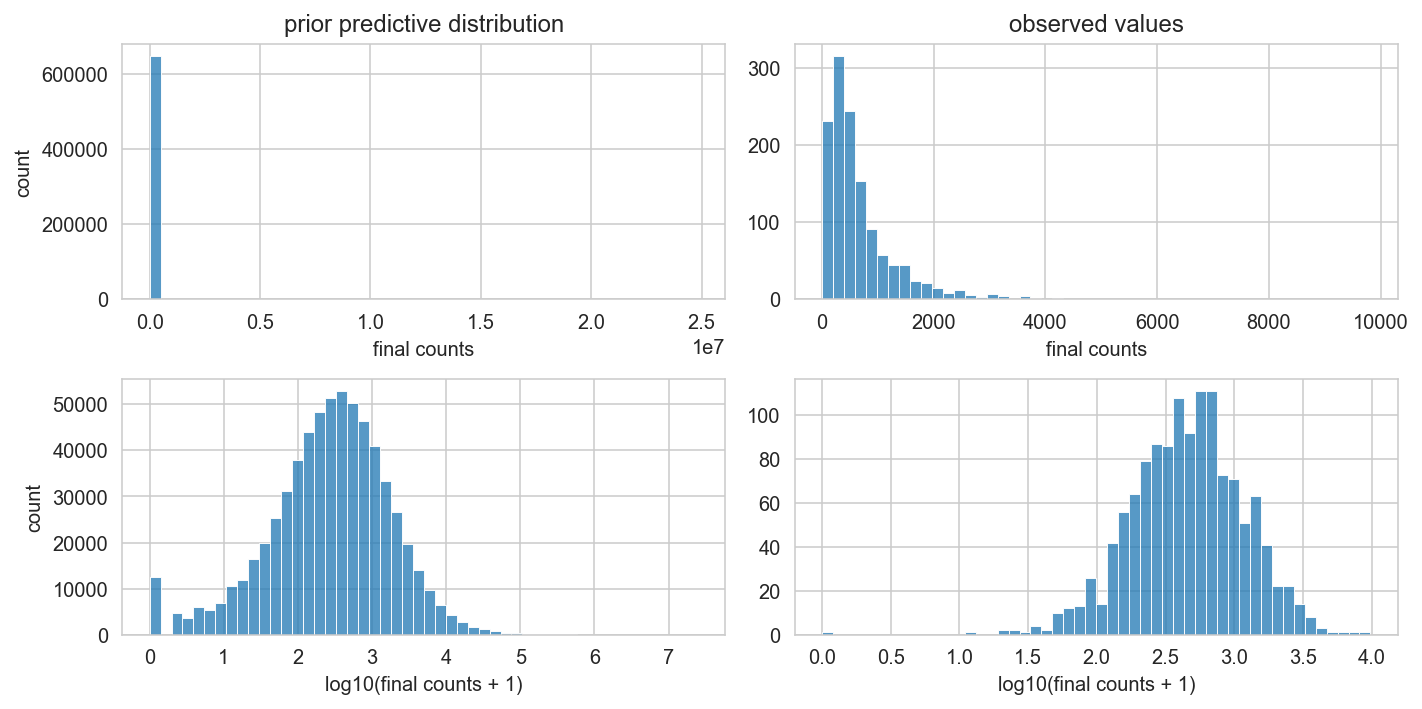

In [109]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

sns.histplot(x=pm_pred_draws.flatten(), ax=axes[0, 0], bins=50)
sns.histplot(x=crc_data["counts_final"], ax=axes[0, 1], bins=50)
sns.histplot(x=np.log10(pm_pred_draws.flatten() + 1), ax=axes[1, 0], bins=50)
sns.histplot(x=np.log10(crc_data["counts_final"] + 1), ax=axes[1, 1], bins=50)

axes[0, 0].set_title("prior predictive distribution")
axes[0, 1].set_title("observed values")

for ax in axes[0, :]:
    ax.set_xlabel("final counts")

for ax in axes[1, :]:
    ax.set_xlabel("log10(final counts + 1)")

for ax in axes[:, 0]:
    ax.set_ylabel("count")
for ax in axes[:, 1]:
    ax.set_ylabel(None)

plt.tight_layout()
plt.show()

## Sampling

In [110]:
with crc_pymc_model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        tune=500,
        target_accept=0.85,
        random_seed=SEED,
    )

Compiling...
Compilation time =  0:00:12.037868
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:01:29.674322
Transforming variables...
Transformation time =  0:00:02.945661
Computing Log Likelihood...
Log Likelihood time =  0:00:03.963440


## Posterior analysis

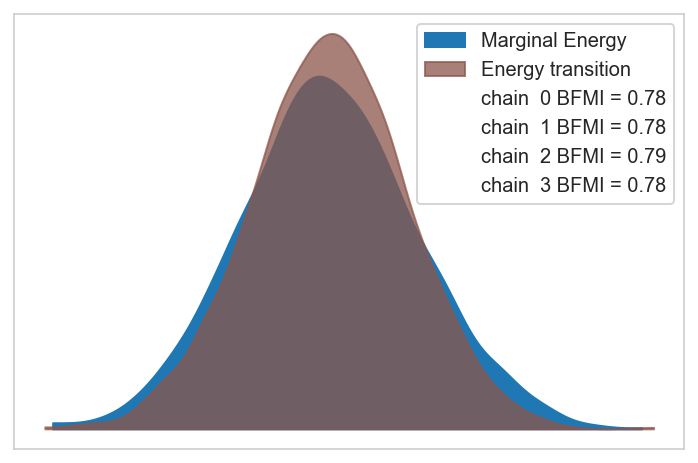

In [111]:
az.plot_energy(trace);

In [112]:
trace.sample_stats.diverging.values.sum(axis=1)

array([0, 0, 0, 0])

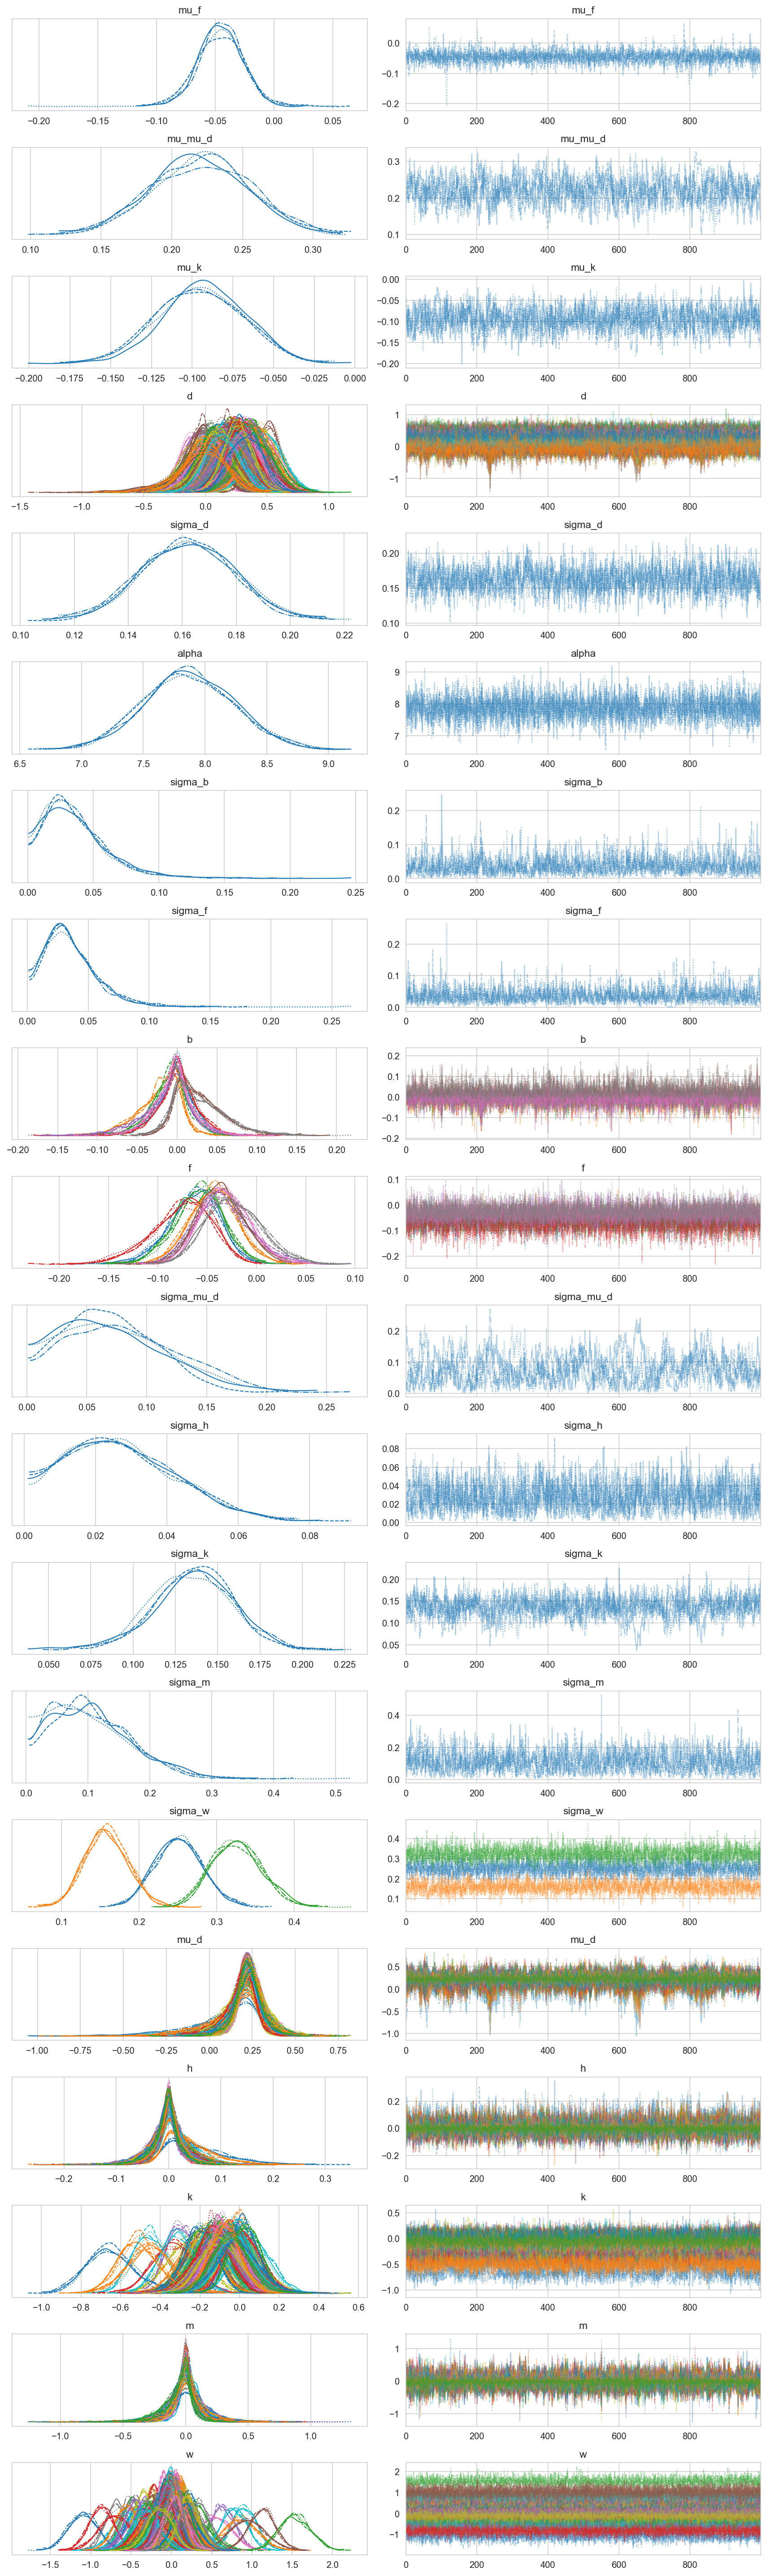

In [113]:
az.plot_trace(trace, var_names=crc_model.vars_regex(), filter_vars="regex")
plt.tight_layout();

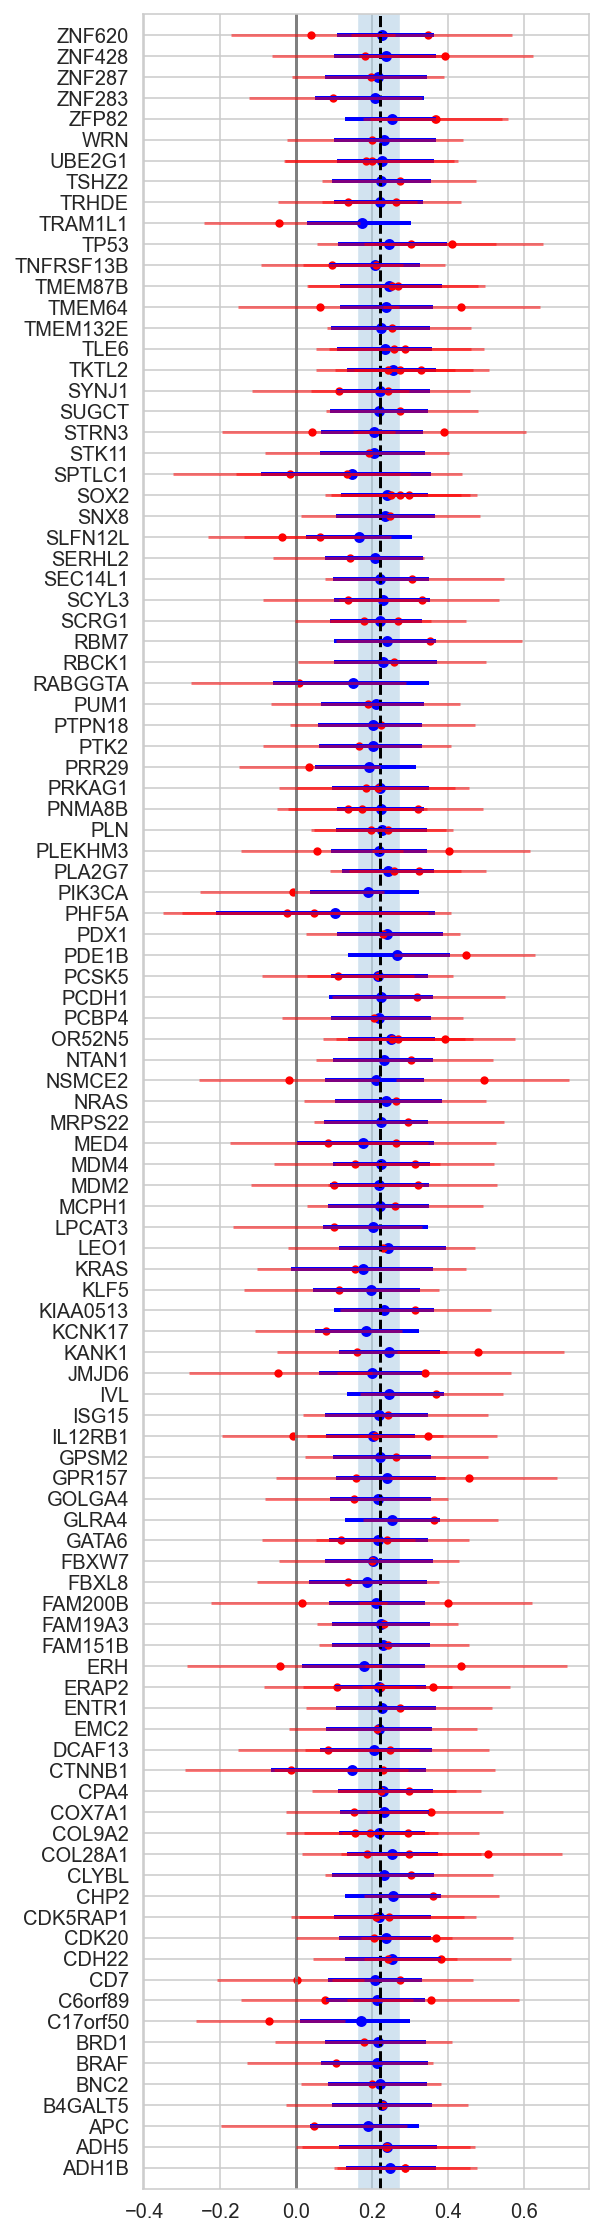

In [117]:
sgrna_to_gene_map = (
    crc_data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)
d_post = (
    az.summary(trace, var_names=["d"], kind="stats")
    .pipe(extract_coords_param_names, names=["sgrna"])
    .reset_index(drop=True)
    .merge(sgrna_to_gene_map, on="sgrna", validate="one_to_one")
)
mu_d_post = (
    az.summary(trace, var_names=["mu_d"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .reset_index(drop=True)
)
mu_mu_d_post = az.summary(trace, var_names=["mu_mu_d"], kind="stats")
assert len(mu_mu_d_post) == 1
mu_mu_d_avg = mu_mu_d_post["mean"][0]
mu_mu_d_hdi = (mu_mu_d_post["hdi_5.5%"][0], mu_mu_d_post["hdi_94.5%"][0])

fig, ax = plt.subplots(figsize=(4, 20))
plt.axvline(0, color="grey")

# Population average and HDI
plt.fill_between(x=mu_mu_d_hdi, y1=-1, y2=len(mu_d_post), alpha=0.2)
plt.axvline(mu_mu_d_avg, color="k", linestyle="--")

# Gene estimates.
plt.hlines(
    y=mu_d_post["hugo_symbol"],
    xmin=mu_d_post["hdi_5.5%"],
    xmax=mu_d_post["hdi_94.5%"],
    color="b",
    linewidth=2,
)
plt.scatter(x=mu_d_post["mean"], y=mu_d_post["hugo_symbol"], s=20, c="b")

# sgRNA estimates.
plt.hlines(
    y=d_post["hugo_symbol"],
    xmin=d_post["hdi_5.5%"],
    xmax=d_post["hdi_94.5%"],
    color="r",
    alpha=0.5,
)
plt.scatter(x=d_post["mean"], y=d_post["hugo_symbol"], s=10, c="r")

plt.ylim(-1, len(mu_d_post))
plt.show()

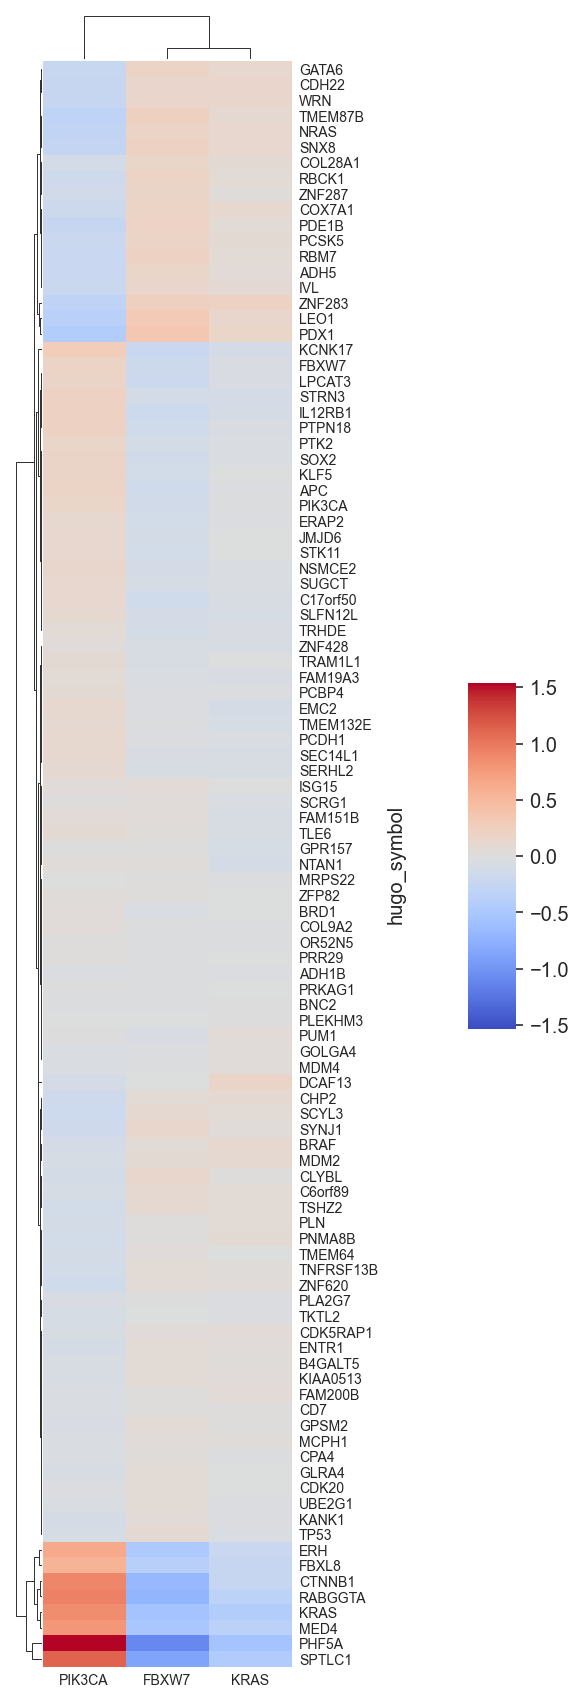

In [118]:
w_post_summary = (
    az.summary(trace, var_names="w", kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol", "cancer_gene"])
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean")
    .set_index("hugo_symbol")
)

vmax = np.abs(w_post_summary.values).max()

figsize = (3.3, 12)
dendro_ratio = (0.1, figsize[0] * 0.1 / figsize[1])
cm = sns.clustermap(
    w_post_summary,
    z_score=None,
    cmap="coolwarm",
    vmin=-vmax,
    vmax=vmax,
    figsize=figsize,
    dendrogram_ratio=dendro_ratio,
    cbar_pos=(1, 0.4, 0.1, 0.2),
    yticklabels=1,
)
cm.ax_heatmap.tick_params("both", labelsize=7, size=0)
plt.show()

In [119]:
pik3ca_hits = w_post_summary.sort_values("PIK3CA").query("PIK3CA > 0.5").index.tolist()
pik3ca_hits

['FBXL8', 'ERH', 'MED4', 'KRAS', 'CTNNB1', 'RABGGTA', 'SPTLC1', 'PHF5A']

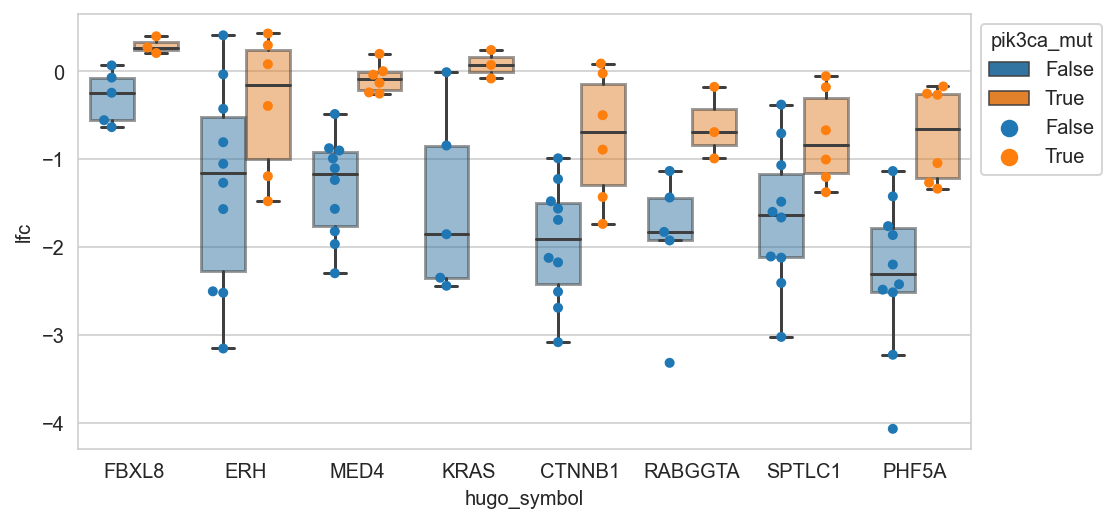

In [120]:
pik3ca_mut_map = (
    crc_data.copy()
    .query("hugo_symbol == 'PIK3CA'")[["depmap_id", "is_mutated"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={"is_mutated": "pik3ca_mut"})
)

pik3ca_hits_data = (
    crc_data.copy()
    .filter_column_isin("hugo_symbol", pik3ca_hits)
    .merge(pik3ca_mut_map, on="depmap_id")
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d["hugo_symbol"], categories=pik3ca_hits, ordered=True
        )
    )
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=pik3ca_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="pik3ca_mut",
    dodge=True,
    ax=ax,
    flierprops={"markersize": 0},
    boxprops={"alpha": 0.5},
)
sns.swarmplot(
    data=pik3ca_hits_data, x="hugo_symbol", y="lfc", hue="pik3ca_mut", dodge=True, ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

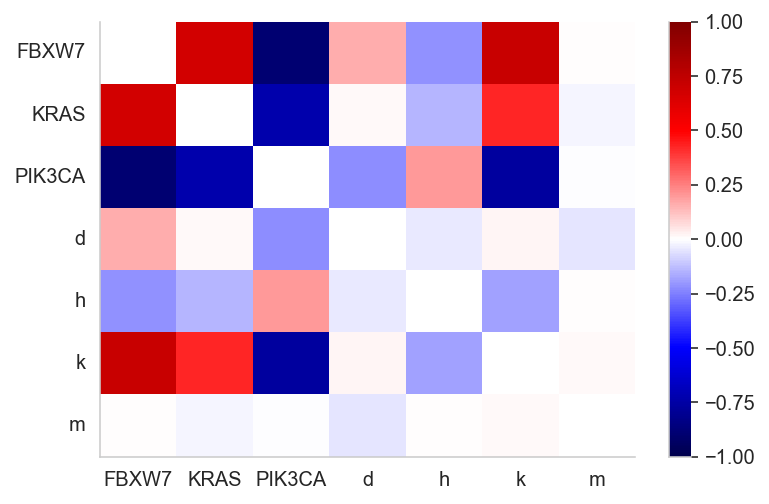

In [121]:
tissue_var_names = ["d", "h", "k", "m"] + list(
    trace.posterior.coords["cancer_gene"].values
)
gene_vars_corr = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["var1", "var2"])
    .astype({"var1": int, "var2": int})
    .assign(
        var1=lambda d: [tissue_var_names[i] for i in d["var1"]],
        var2=lambda d: [tissue_var_names[i] for i in d["var2"]],
    )
)
gene_vars_corr.loc[gene_vars_corr["var1"] == gene_vars_corr["var2"], "mean"] = np.nan
gene_vars_corr = gene_vars_corr.pivot_wider(
    "var1", names_from="var2", values_from="mean"
).set_index("var1")

hm = sns.heatmap(gene_vars_corr, cmap="seismic", vmin=-1, vmax=1)
sns.despine()
hm.set_xlabel(None)
hm.set_ylabel(None)
plt.show()

---

In [122]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 57.45 minutes


In [123]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-04

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: simplify

matplotlib: 3.5.2
seaborn   : 0.11.2
plotnine  : 0.0.0
arviz     : 0.12.1
pandas    : 1.4.3
pymc      : 4.0.1
numpy     : 1.23.0

